In [1]:
# Mock Data
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, datetime, date, timedelta
from mockseries.trend import LinearTrend
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise
from datetime import datetime
from mockseries.utils import datetime_range
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import random


## Snowpark 
import snowflake.snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col
from snowflake.snowpark.types import *
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions

# Model Deployment
from time import time
import io
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Creates the trend and seasonality for mock data

In [2]:
trend = LinearTrend(coefficient= .1, time_unit=timedelta(days=4), flat_base=100)
seasonality = \
SinusoidalSeasonality(amplitude=20, period=timedelta(days=7)) \
+ SinusoidalSeasonality(amplitude=4, period=timedelta(days=1))
noise = RedNoise(mean=0, std=3, correlation=0.5)
timeseries = trend + seasonality + noise

## Create daily mock time series data from Janurary 2020 - Current Day

In [3]:
time_points = datetime_range(
    granularity=timedelta(days=1),
    start_time=datetime.datetime(2020,1,1),
    end_time= datetime.datetime.today(),
)
ts_values = timeseries.generate(time_points=time_points)

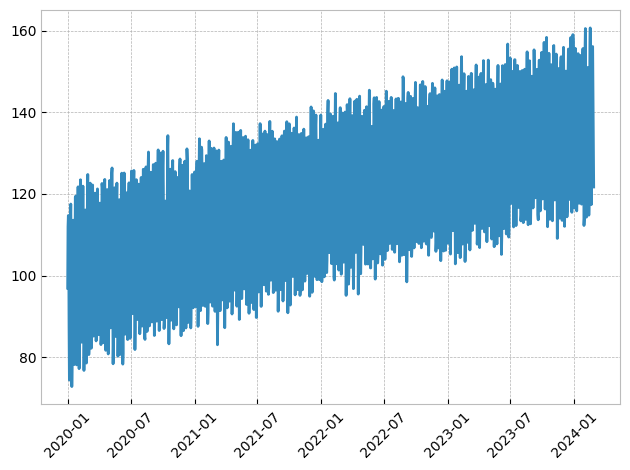

In [4]:
from mockseries.utils import plot_timeseries, write_csv
plot_timeseries(time_points, ts_values)

In [5]:
import pandas as pd
df = pd.DataFrame({"DATE":time_points,"TRAFFIC":ts_values})
df.head()

,DATE,TRAFFIC
0,2020-01-01,96.942483
1,2020-01-02,112.012114
2,2020-01-03,114.728719
3,2020-01-04,107.652657
4,2020-01-05,87.51364


## Create a unique time series for 1000 different stores

In [6]:
dfs = []

for i in range (1,1001):
    _ = df.copy()
    _['STORE_ID'] = i
    _['TRAFFIC'] = _['TRAFFIC']*random.uniform(.60, 1.40)
    dfs.append(_)

df = pd.concat(dfs)

## Create the final dataframe by rounding the traffic value to mimic realistic foot traffic

In [7]:
df['TRAFFIC'] = df['TRAFFIC'].astype(int)

In [8]:
df.tail()

,DATE,TRAFFIC,STORE_ID
1513,2024-02-22,141,1000
1514,2024-02-23,141,1000
1515,2024-02-24,130,1000
1516,2024-02-25,115,1000
1517,2024-02-26,110,1000


## Connect to snowflake to load our mock data

In [9]:
session = Session.builder.configs(SnowflakeLoginOptions()).getOrCreate()

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


## Turn Pandas Dataframe into a Snowpark Dataframe so we can upload it to snowflake

In [10]:
session.sql('create database if not exists store_traffic').collect()
session.sql('create schema if not exists time_series').collect()

[Row(status='TIME_SERIES already exists, statement succeeded.')]

In [11]:
session.use_database('store_traffic')
session.use_schema('time_series')

In [12]:
final_snow_df = session.create_dataframe(df).select('DATE','TRAFFIC','STORE_ID')

In [13]:
final_snow_df.show()

------------------------------------------------
|"DATE"               |"TRAFFIC"  |"STORE_ID"  |
------------------------------------------------
|2020-01-01 00:00:00  |125        |1           |
|2020-01-02 00:00:00  |145        |1           |
|2020-01-03 00:00:00  |148        |1           |
|2020-01-04 00:00:00  |139        |1           |
|2020-01-05 00:00:00  |113        |1           |
|2020-01-06 00:00:00  |96         |1           |
|2020-01-07 00:00:00  |107        |1           |
|2020-01-08 00:00:00  |130        |1           |
|2020-01-09 00:00:00  |146        |1           |
|2020-01-10 00:00:00  |152        |1           |
------------------------------------------------



In [14]:
final_snow_df = final_snow_df.select(
    F.cast(F.to_varchar("DATE"), DateType()).alias("DATE"), "STORE_ID", "TRAFFIC"
)
final_snow_df.show()

---------------------------------------
|"DATE"      |"STORE_ID"  |"TRAFFIC"  |
---------------------------------------
|2020-01-01  |1           |125        |
|2020-01-02  |1           |145        |
|2020-01-03  |1           |148        |
|2020-01-04  |1           |139        |
|2020-01-05  |1           |113        |
|2020-01-06  |1           |96         |
|2020-01-07  |1           |107        |
|2020-01-08  |1           |130        |
|2020-01-09  |1           |146        |
|2020-01-10  |1           |152        |
---------------------------------------



In [15]:
final_snow_df.write.saveAsTable('store_traffic.time_series.traffic', mode='overwrite', create_temp_table=False)

## Create calendar table with holidays

In [16]:
def create_date_table(start='2018-01-01', end='2025-12-31'):
    df = pd.DataFrame({"CALENDAR_DATE": pd.date_range(start, end)})
    df["CALENDAR_WEEK_DAY_NBR"] = df.CALENDAR_DATE.dt.dayofweek
    df["CALENDAR_MTH_DAY_NBR"] = df.CALENDAR_DATE.dt.day
    df["CALENDAR_MTH"] = df.CALENDAR_DATE.dt.month
    df["CALENDAR_YEAR"] = df.CALENDAR_DATE.dt.year
    return df

In [17]:
calendar_df = create_date_table()

In [18]:
calendar = USFederalHolidayCalendar()
holiday_df = (
    pd.DataFrame(
        calendar.holidays(start='2018-01-01', end='2025-12-31', return_name=True)
    )
    .reset_index()
    .rename(columns={"index": "date", 0: "holiday_name"})
)

In [19]:
holiday_df['date'] = holiday_df['date'].dt.date

In [20]:
calendar_df['CALENDAR_DATE'] = calendar_df['CALENDAR_DATE'].dt.date

In [21]:
calendar_final = calendar_df.merge(holiday_df, left_on='CALENDAR_DATE', right_on='date', how = 'left')

In [22]:
calendar_final = calendar_final.rename(columns={"holiday_name":"HOLIDAY_NAME"})
calendar_final_snow_df = session.create_dataframe(calendar_final).select('CALENDAR_DATE','CALENDAR_WEEK_DAY_NBR','CALENDAR_MTH_DAY_NBR','CALENDAR_MTH','CALENDAR_YEAR','HOLIDAY_NAME')

In [23]:
calendar_final_snow_df = calendar_final_snow_df.\
select(col('CALENDAR_DATE'),\
       col('CALENDAR_WEEK_DAY_NBR').cast(StringType()).alias('WEEK_DAY_NBR'),\
       col('CALENDAR_MTH_DAY_NBR').cast(StringType()).alias('MTH_DAY_NBR'),\
       col('CALENDAR_MTH').cast(StringType()).alias('CALENDAR_MTH'),\
       col('CALENDAR_YEAR').cast(StringType()).alias('CALENDAR_YEAR'),\
       col('HOLIDAY_NAME'))

In [24]:
calendar_final_snow_df.show()

--------------------------------------------------------------------------------------------------------
|"CALENDAR_DATE"  |"WEEK_DAY_NBR"  |"MTH_DAY_NBR"  |"CALENDAR_MTH"  |"CALENDAR_YEAR"  |"HOLIDAY_NAME"  |
--------------------------------------------------------------------------------------------------------
|2018-01-01       |0               |1              |1               |2018             |New Year's Day  |
|2018-01-02       |1               |2              |1               |2018             |NULL            |
|2018-01-03       |2               |3              |1               |2018             |NULL            |
|2018-01-04       |3               |4              |1               |2018             |NULL            |
|2018-01-05       |4               |5              |1               |2018             |NULL            |
|2018-01-06       |5               |6              |1               |2018             |NULL            |
|2018-01-07       |6               |7              |1  

In [25]:
calendar_final_snow_df.write.saveAsTable('store_traffic.time_series.CALENDAR_INFO_2018', mode='overwrite', create_temp_table=False)